In [1]:
# import packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
from imutils.video import VideoStream
import imutils
import time
import cv2
import os

In [2]:
def detect_and_predict_mask(frame, faceNet, maskNet):
	
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
		(104.0, 177.0, 123.0))

	faceNet.setInput(blob)
	detections = faceNet.forward()
	print(detections.shape)

	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		confidence = detections[0, 0, i, 2]

		if confidence > 0.5:
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)

	return (locs, preds)

In [3]:
# load serialized face detector model from disk
prototxtPath = r"face_detector\deploy.prototxt"
weightsPath = r"face_detector\res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

In [4]:
# load model from disk
maskNet = load_model("mask_detector.h5")

In [5]:
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()


[INFO] starting video stream...


(1, 1, 200, 7)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


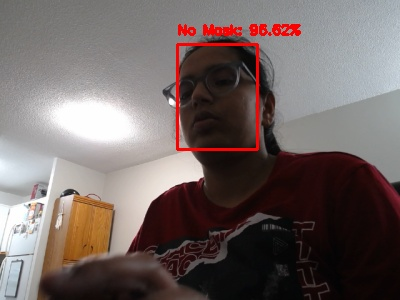

In [6]:
from IPython.display import display, Image, clear_output

# Initialize the video stream
vs = VideoStream(src=0).start()  # Use 'src=0' for the webcam or the path to the video file

# Allow some time for the camera to warm up
time.sleep(2.0)

# Loop over the frames from the video stream
while True:
    # Read the frame from the video stream
    frame = vs.read()

    # Check if frame was read successfully
    if frame is None:
        print("[ERROR] Could not read frame from the video stream.")
        break

    # Resize the frame to have a width of 400 pixels
    frame = imutils.resize(frame, width=400)

    # Perform mask detection on the frame
    (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

    # Loop over the detected face locations and their corresponding predictions
    for (box, pred) in zip(locs, preds):
        # Unpack the bounding box and predictions
        (startX, startY, endX, endY) = box
        (mask, withoutMask) = pred

        # Determine the label and color to draw the bounding box and text
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

        # Include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

        # Display the label and bounding box rectangle on the frame
        cv2.putText(frame, label, (startX, startY - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

    # Convert the frame to an image format that Jupyter can display
    _, jpeg = cv2.imencode('.jpg', frame)
    display(Image(data=jpeg.tobytes()))

    # Wait for a short period before showing the next frame
    time.sleep(0.05)
    
    # Clear the output to display the next frame
    clear_output(wait=True)